In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import os
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
matplotlib.style.use('ggplot')
%matplotlib inline

In [2]:
from skimage import io, color, filters

from PIL import Image
import requests
from io import BytesIO
from imageio import imread

## Read in Labels

In [3]:
df = pd.read_csv('../data/data_final.csv')
df

,ID,Name,Primary Type,Secondary Type,Image,Additional Images
0,#001,bulbasaur,Grass,Poison,https://img.pokemondb.net/sprites/bank/normal/...,['https://img.pokemondb.net/artwork/bulbasaur....
1,#002,ivysaur,Grass,Poison,https://img.pokemondb.net/sprites/bank/normal/...,['https://img.pokemondb.net/artwork/ivysaur.jp...
2,#003,venusaur,Grass,Poison,https://img.pokemondb.net/sprites/bank/normal/...,['https://img.pokemondb.net/artwork/venusaur.j...
3,#004,charmander,Fire,NaN,https://img.pokemondb.net/sprites/bank/normal/...,['https://img.pokemondb.net/artwork/charmander...
4,#005,charmeleon,Fire,NaN,https://img.pokemondb.net/sprites/bank/normal/...,['https://img.pokemondb.net/artwork/charmeleon...
...,...,...,...,...,...,...
893,#894,regieleki,Electric,NaN,https://img.pokemondb.net/sprites/sword-shield...,['https://img.pokemondb.net/artwork/regieleki....
894,#895,regidrago,Dragon,NaN,https://img.pokemondb.net/sprites/sword-shield...,['https://img.pokemondb.net/artwork/regidrago....
895,#896,glastrier,Ice,NaN,https://img.pokemondb.net/sprites/sword-shield...,['https://img.pokemondb.net/artwork/glastrier....
896,#897,spectrier,Ghost,NaN,https://img.pokemondb.net/sprites/sword-shield...,['https://img.pokemondb.net/artwork/spectrier....


## Functions for Retrieving Images

In [4]:
def get_file_paths(path):
    '''
    Takes a folder path and returns a set of all file paths of .jpg in the folders
    Input: Folder path
    '''
    file_set = set()

    for direct, _, files in os.walk(path):
        for file_name in files:
            rel_dir = os.path.relpath(direct, path)
            rel_file = os.path.join(rel_dir, file_name)
            if '.png' not in rel_file:
                continue
            file_set.add(str(path)+rel_file)

    return file_set

def one_hotify(y, n_classes=None):
    '''Convert array of integers to one-hot format;
    The new dimension is added at the end.'''
    if n_classes is None:
        n_classes = max(y) + 1
    labels = np.arange(n_classes)
    y = y[..., None]
    return (y == labels).astype(int)

def load_images(path,size=(256,256)):
    
    file_paths = get_file_paths(path)
    
    images = []
    y = []
    for file in file_paths:
        img = keras.preprocessing.image.load_img(file, target_size=size)
        img_arr = keras.preprocessing.image.img_to_array(img.convert('RGBA'))[:,:,0:3]
        images.append(img_arr/255)
        y.append(file.split('/')[-1].split('_')[0])
    return images, y

In [5]:
pokedict = {}
for i in range(df.shape[0]):
    if str(df['Secondary Type'].loc[i]) != 'nan':
        pokedict[df['Name'].loc[i]] = [df['Primary Type'].loc[i], df['Secondary Type'].loc[i]]
    else:
        pokedict[df['Name'].loc[i]] = [df['Primary Type'].loc[i]]

## Read Data

In [6]:
X,y_names = load_images(('../images/'))
X = np.array(X)

In [7]:
y_type = []
for name in y_names:
    y_type.append(pokedict[name])
    
y = pd.Series(y_type)
y = pd.get_dummies(y.apply(pd.Series).stack()).sum(level=0)
y

,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8355,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
8356,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
8357,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
8358,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0


## Split into Train, Test, and Validation Sets

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=46, test_size=0.2,stratify = y)

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=46, test_size=0.2,stratify = y_train)

## Determine Class Weights

In [13]:
class_dict = {}
sums = np.sum(y, axis = 0)
for i in range(y.shape[1]):
    class_dict[i] = sums[i]

In [15]:
for key,value in class_dict.items():
    class_dict[key] = 1462/value

In [168]:
def create_neural_net(model):
    model.add(keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(256, 256, 3)))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(keras.layers.Dropout(0.25))

    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(keras.layers.Dropout(0.25))

    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(keras.layers.Dropout(0.25))

    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(keras.layers.Dropout(0.25))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(18,
                    activation='sigmoid',
                    kernel_regularizer=keras.regularizers.l2(0.01)))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(thresholds = 0.4),tf.keras.metrics.Recall(thresholds = 0.4)])

In [21]:
final_model = keras.models.Sequential()
create_neural_net(final_model)

In [22]:
final_model.fit(X_train, y_train, epochs=200, validation_data=(X_val, y_val), batch_size=16,class_weight = class_dict)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/200
335/335 [==============================] - 140s 414ms/step - loss: 0.9016 - accuracy: 0.0493 - precision: 0.0975 - recall: 0.0723 - val_loss: 0.3704 - val_accuracy: 0.0531 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/200
335/335 [==============================] - 116s 348ms/step - loss: 0.7032 - accuracy: 0.0587 - precision: 0.1753 - recall: 0.0019 - val_loss: 0.3319 - val_accuracy: 0.1016 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/200
335/335 [==============================] - 121s 361ms/step - loss: 0.6698 - accuracy: 0.0665 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.3236 - val_accuracy: 0.0531 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/200
335/335 [==============================] - 141s 420ms/step - loss: 0.6583 - accuracy: 0.0628 - precision: 0.0000e+00 - recall: 0.00

Epoch 34/200
335/335 [==============================] - 126s 375ms/step - loss: 0.5051 - accuracy: 0.2495 - precision: 0.6006 - recall: 0.1912 - val_loss: 0.2692 - val_accuracy: 0.2339 - val_precision: 0.7950 - val_recall: 0.0856
Epoch 35/200
335/335 [==============================] - 110s 328ms/step - loss: 0.4927 - accuracy: 0.2639 - precision: 0.6103 - recall: 0.2059 - val_loss: 0.2653 - val_accuracy: 0.2354 - val_precision: 0.7634 - val_recall: 0.1090
Epoch 36/200
335/335 [==============================] - 111s 331ms/step - loss: 0.4896 - accuracy: 0.2729 - precision: 0.6112 - recall: 0.2170 - val_loss: 0.2633 - val_accuracy: 0.2549 - val_precision: 0.7560 - val_recall: 0.1284
Epoch 37/200
335/335 [==============================] - 111s 330ms/step - loss: 0.4803 - accuracy: 0.2826 - precision: 0.6137 - recall: 0.2325 - val_loss: 0.2652 - val_accuracy: 0.2586 - val_precision: 0.7568 - val_recall: 0.1009
Epoch 38/200
335/335 [==============================] - 110s 329ms/step - loss: 

Epoch 70/200
335/335 [==============================] - 110s 327ms/step - loss: 0.3708 - accuracy: 0.4159 - precision: 0.7122 - recall: 0.4522 - val_loss: 0.2288 - val_accuracy: 0.3109 - val_precision: 0.8502 - val_recall: 0.2761
Epoch 71/200
335/335 [==============================] - 109s 326ms/step - loss: 0.3765 - accuracy: 0.4127 - precision: 0.7120 - recall: 0.4471 - val_loss: 0.2313 - val_accuracy: 0.2967 - val_precision: 0.8552 - val_recall: 0.2554
Epoch 72/200
335/335 [==============================] - 110s 329ms/step - loss: 0.3741 - accuracy: 0.4138 - precision: 0.7158 - recall: 0.4449 - val_loss: 0.2267 - val_accuracy: 0.3259 - val_precision: 0.8614 - val_recall: 0.2883
Epoch 73/200
335/335 [==============================] - 109s 326ms/step - loss: 0.3729 - accuracy: 0.4230 - precision: 0.7225 - recall: 0.4519 - val_loss: 0.2277 - val_accuracy: 0.3049 - val_precision: 0.8554 - val_recall: 0.2905
Epoch 74/200
335/335 [==============================] - 110s 326ms/step - loss: 

Epoch 106/200
335/335 [==============================] - 110s 327ms/step - loss: 0.3325 - accuracy: 0.4735 - precision: 0.7550 - recall: 0.5325 - val_loss: 0.2150 - val_accuracy: 0.3251 - val_precision: 0.8512 - val_recall: 0.3608
Epoch 107/200
335/335 [==============================] - 110s 328ms/step - loss: 0.3276 - accuracy: 0.4832 - precision: 0.7542 - recall: 0.5433 - val_loss: 0.2166 - val_accuracy: 0.3296 - val_precision: 0.8337 - val_recall: 0.3635
Epoch 108/200
335/335 [==============================] - 110s 329ms/step - loss: 0.3315 - accuracy: 0.4692 - precision: 0.7522 - recall: 0.5276 - val_loss: 0.2142 - val_accuracy: 0.3117 - val_precision: 0.8350 - val_recall: 0.3716
Epoch 109/200
335/335 [==============================] - 109s 326ms/step - loss: 0.3374 - accuracy: 0.4501 - precision: 0.7547 - recall: 0.5247 - val_loss: 0.2165 - val_accuracy: 0.3169 - val_precision: 0.8382 - val_recall: 0.3383
Epoch 110/200
335/335 [==============================] - 110s 328ms/step - l

335/335 [==============================] - 110s 327ms/step - loss: 0.3086 - accuracy: 0.4938 - precision: 0.7740 - recall: 0.5814 - val_loss: 0.2077 - val_accuracy: 0.3117 - val_precision: 0.8425 - val_recall: 0.4023
Epoch 142/200
335/335 [==============================] - 109s 326ms/step - loss: 0.3106 - accuracy: 0.5007 - precision: 0.7733 - recall: 0.5796 - val_loss: 0.2088 - val_accuracy: 0.3236 - val_precision: 0.8509 - val_recall: 0.4063
Epoch 143/200
335/335 [==============================] - 109s 326ms/step - loss: 0.3158 - accuracy: 0.4817 - precision: 0.7668 - recall: 0.5730 - val_loss: 0.2080 - val_accuracy: 0.3244 - val_precision: 0.8546 - val_recall: 0.3838
Epoch 144/200
335/335 [==============================] - 110s 327ms/step - loss: 0.3119 - accuracy: 0.5015 - precision: 0.7743 - recall: 0.5789 - val_loss: 0.2066 - val_accuracy: 0.3087 - val_precision: 0.8344 - val_recall: 0.4086
Epoch 145/200
335/335 [==============================] - 109s 326ms/step - loss: 0.3034 - 

335/335 [==============================] - 110s 327ms/step - loss: 0.2893 - accuracy: 0.5155 - precision: 0.7834 - recall: 0.6213 - val_loss: 0.1996 - val_accuracy: 0.3012 - val_precision: 0.8265 - val_recall: 0.4419
Epoch 177/200
335/335 [==============================] - 110s 328ms/step - loss: 0.2886 - accuracy: 0.5179 - precision: 0.7848 - recall: 0.6285 - val_loss: 0.2019 - val_accuracy: 0.3154 - val_precision: 0.8587 - val_recall: 0.4270
Epoch 178/200
335/335 [==============================] - 110s 329ms/step - loss: 0.2929 - accuracy: 0.5129 - precision: 0.7805 - recall: 0.6201 - val_loss: 0.2031 - val_accuracy: 0.3019 - val_precision: 0.8395 - val_recall: 0.4288
Epoch 179/200
335/335 [==============================] - 110s 327ms/step - loss: 0.2878 - accuracy: 0.5178 - precision: 0.7839 - recall: 0.6254 - val_loss: 0.2015 - val_accuracy: 0.3146 - val_precision: 0.8312 - val_recall: 0.4369
Epoch 180/200
335/335 [==============================] - 110s 328ms/step - loss: 0.2866 - 

In [24]:
final_model.evaluate(X_test, y_test)

53/53 [==============================] - 8s 136ms/step - loss: 0.1960 - accuracy: 0.3074 - precision: 0.8390 - recall: 0.4863


[0.19603998959064484,
 0.30741626024246216,
 0.8390304446220398,
 0.4863112270832062]

In [25]:
final_model.evaluate(X_val, y_val)

42/42 [==============================] - 6s 134ms/step - loss: 0.2012 - accuracy: 0.2915 - precision: 0.8350 - recall: 0.4559


[0.20124825835227966,
 0.29147982597351074,
 0.8349835276603699,
 0.4558558464050293]

In [26]:
final_model.evaluate(X_train, y_train)

168/168 [==============================] - 26s 153ms/step - loss: 0.0745 - accuracy: 0.6264 - precision: 0.9918 - recall: 0.8546


[0.07454218715429306,
 0.6263551115989685,
 0.991769015789032,
 0.8546498417854309]

Fighting 54.8%
Psychic 17.9%
Dark 3.51%
Fire 3.19%
Steel 2.24%


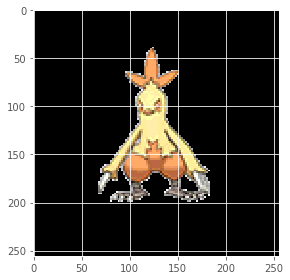

In [73]:
img = X_test[50]
classes = np.array(y_train.columns)
proba = final_model.predict(img.reshape(1,256,256,3))
top_3 = np.argsort(proba[0])[:-6:-1]
for i in range(5):
    print("{}".format(classes[top_3[i]])+" {:.3}%".format(proba[0][top_3[i]]*100))
io.imshow(img);

In [97]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import recall_score,precision_score

In [159]:
dummy_clf = DummyClassifier(strategy = 'stratified')

In [160]:
dummy_clf.fit(X_train,y_train)

DummyClassifier(strategy='stratified')

In [161]:
dummy_clf.score(X_test,y_test)

0.01076555023923445

In [162]:
ydummypred = dummy_clf.predict(X_test)

In [163]:
recall_score(pd.DataFrame.to_numpy(y_test),ydummypred, average = 'micro')

0.11707492795389049

In [164]:
precision_score(pd.DataFrame.to_numpy(y_test),ydummypred, average = 'micro')

0.11363636363636363

In [158]:
ydummypred[0:5]

array([[0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1],
       [0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1],
       [1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0],
       [1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1],
       [1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1]],
      dtype=uint8)

In [128]:
final_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 127, 127, 16)      0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 60, 60, 64)       

In [137]:
colors = ['#a8b820', '#705848', '#7038f8','#f8D030','#ee99ac','#c03028','#f08030','#a890f0','#705898','#78c850','#e0C068','#98d8d8','#a8a878','#a040a0','#f85888','#b8a038','#b8b8D0','#6890f0']

In [141]:
y.sum(axis=0).values

array([ 888,  575,  529,  492,  503,  527,  620, 1341,  484,  988,  825,
        441, 1012,  874,  936,  788,  593, 1462])

Text(0.5, 1.0, 'Amount of Images by Type')

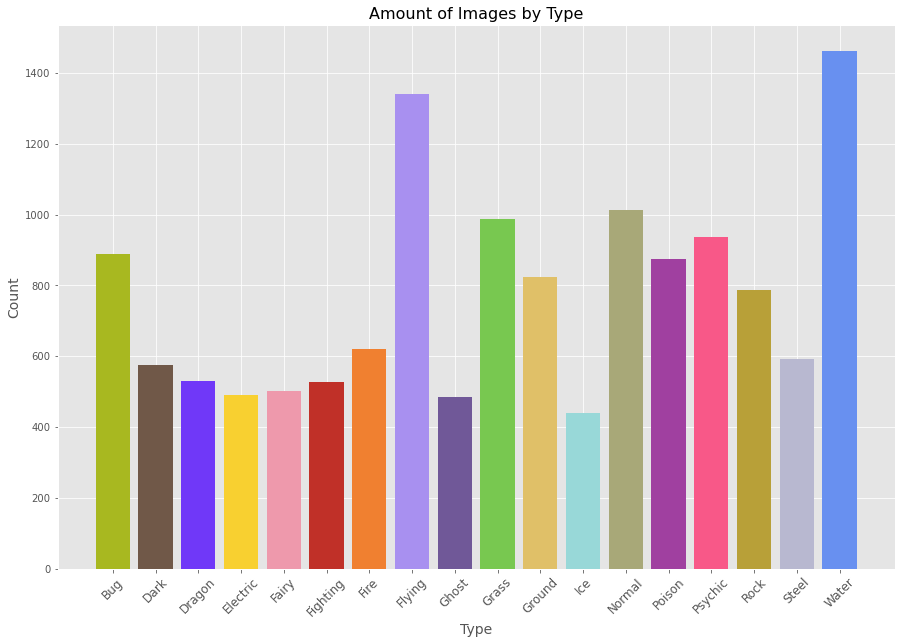

In [145]:
fig,ax = plt.subplots(figsize= (15,10))
ax.bar(range(0,18), y.sum(axis=0).values, color = colors)
ax.set_xticks(range(0,18))
ax.set_xticklabels(y.columns, size = 12)
plt.xticks(rotation = 45);
ax.set_xlabel('Type', size = 14)
ax.set_ylabel('Count', size = 14)
ax.set_title('Amount of Images by Type', size = 16)

In [166]:
final_model.save('../data/my_model')

INFO:tensorflow:Assets written to: ../data/my_model/assets
